In [1]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import tarfile
import urllib.request

from tqdm import tqdm
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import get_linear_schedule_with_warmup
from tokenizers import Tokenizer, models, pre_tokenizers, trainers
from transformers import BertTokenizer, BertForSequenceClassification

In [2]:
!pip install tokenizers transformers

### **데이터 수집**

In [3]:
# 1. 데이터셋 다운로드 및 로드
def download_imdb_dataset():
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    dataset_path = './aclImdb_v1.tar.gz'
    if not os.path.exists(dataset_path):
        urllib.request.urlretrieve(url, dataset_path)
    if not os.path.exists('./aclImdb'):
        with tarfile.open(dataset_path, 'r:gz') as tar:
            tar.extractall()

download_imdb_dataset()

# 2. 데이터 파싱
def load_imdb_dataset(path):
    texts = []
    labels = []

    for directory in ['pos', 'neg']:
        dir_path = os.path.join(path, directory)
        for filename in os.listdir(dir_path):
            with open(os.path.join(dir_path, filename), 'r', encoding='utf-8') as file:
                texts.append(file.read())
                labels.append(1 if directory == 'pos' else 0)

    return texts, labels

train_texts, train_labels = load_imdb_dataset('./aclImdb/train')
test_texts, test_labels = load_imdb_dataset('./aclImdb/test')

train_texts, valid_texts, train_labels, valid_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)

### **LSTM**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# BPE 토크나이저 설정
tokenizer = Tokenizer(models.BPE(unk_token="<UNK>"))
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
bpe_trainer = trainers.BpeTrainer(special_tokens=["<UNK>"])
tokenizer.train_from_iterator(train_texts, trainer=bpe_trainer)

# PyTorch Dataset 정의
class IMDBDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = [tokenizer.encode(text).ids for text in texts]
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        return torch.tensor(self.texts[index], dtype=torch.long), torch.tensor(self.labels[index], dtype=torch.long)

def collate_batch(batch):
    text_list, label_list = zip(*batch)
    padded_text = pad_sequence(text_list, batch_first=True, padding_value=0)
    label_tensor = torch.tensor(label_list, dtype=torch.long)

    return padded_text.to(device), label_tensor.to(device)

train_dataset = IMDBDataset(train_texts, train_labels)
valid_dataset = IMDBDataset(valid_texts, valid_labels)
test_dataset = IMDBDataset(test_texts, test_labels)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid_dataset, batch_size=20, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False, collate_fn=collate_batch)

In [ ]:
# 데이터 로더 예시
for text, label in train_loader:
    print(text, label)
    break

tensor([[ 3995,   344,   217,  ...,     0,     0,     0],
        [  232,  7654, 14999,  ...,     0,     0,     0],
        [   43,   493,   185,  ...,     0,     0,     0],
        ...,
        [  355,   245,  1893,  ...,     0,     0,     0],
        [ 2777,   521,   745,  ...,   174,   590,    16],
        [  355,   227,    67,  ...,     0,     0,     0]], device='cuda:0') tensor([0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
       device='cuda:0')


In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, _) = self.lstm(embedded)
        hidden = hidden.squeeze(0)
        return self.fc(hidden)

model = LSTMClassifier(vocab_size=len(tokenizer.get_vocab()), embedding_dim=100, hidden_dim=256, output_dim=1)
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

train_losses = []
valid_losses = []

for epoch in range(10):
    model.train()
    train_loss = 0
    for texts, labels in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    scheduler.step()

    model.eval()
    valid_loss = 0
    valid_correct = 0
    total = 0
    with torch.no_grad():
        for texts, labels in tqdm(valid_loader, desc=f"Valid Epoch {epoch+1}"):
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs.squeeze(), labels.float())
            valid_loss += loss.item()
            predicted = (torch.sigmoid(outputs.squeeze()) > 0.5).float()
            total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()
    valid_loss /= len(valid_loader)
    valid_losses.append(valid_loss)
    valid_accuracy = 100 * valid_correct / total
    print(f'Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}, Validation Acc: {valid_accuracy}%')

Valid Epoch 1: 100%|██████████| 250/250 [00:03<00:00, 63.30it/s]


Training Loss: 0.6936, Validation Loss: 0.6923, Validation Acc: 50.46%


Valid Epoch 2: 100%|██████████| 250/250 [00:04<00:00, 58.45it/s]


Training Loss: 0.6923, Validation Loss: 0.6910, Validation Acc: 50.36%


Valid Epoch 3: 100%|██████████| 250/250 [00:04<00:00, 62.31it/s]


Training Loss: 0.6890, Validation Loss: 0.6902, Validation Acc: 50.46%


Valid Epoch 4: 100%|██████████| 250/250 [00:04<00:00, 61.61it/s]


Training Loss: 0.6866, Validation Loss: 0.6917, Validation Acc: 50.52%


Valid Epoch 5: 100%|██████████| 250/250 [00:04<00:00, 59.78it/s]


Training Loss: 0.6819, Validation Loss: 0.6924, Validation Acc: 50.54%


Valid Epoch 6: 100%|██████████| 250/250 [00:04<00:00, 61.46it/s]


Training Loss: 0.6691, Validation Loss: 0.6655, Validation Acc: 63.38%


Valid Epoch 7: 100%|██████████| 250/250 [00:04<00:00, 59.07it/s]


Training Loss: 0.5536, Validation Loss: 0.4881, Validation Acc: 77.28%


Valid Epoch 8: 100%|██████████| 250/250 [00:04<00:00, 61.39it/s]


Training Loss: 0.3426, Validation Loss: 0.3474, Validation Acc: 84.98%


Valid Epoch 9: 100%|██████████| 250/250 [00:04<00:00, 59.07it/s]


Training Loss: 0.2177, Validation Loss: 0.3381, Validation Acc: 87.18%


Valid Epoch 10: 100%|██████████| 250/250 [00:04<00:00, 61.32it/s]

Training Loss: 0.1360, Validation Loss: 0.3712, Validation Acc: 86.14%


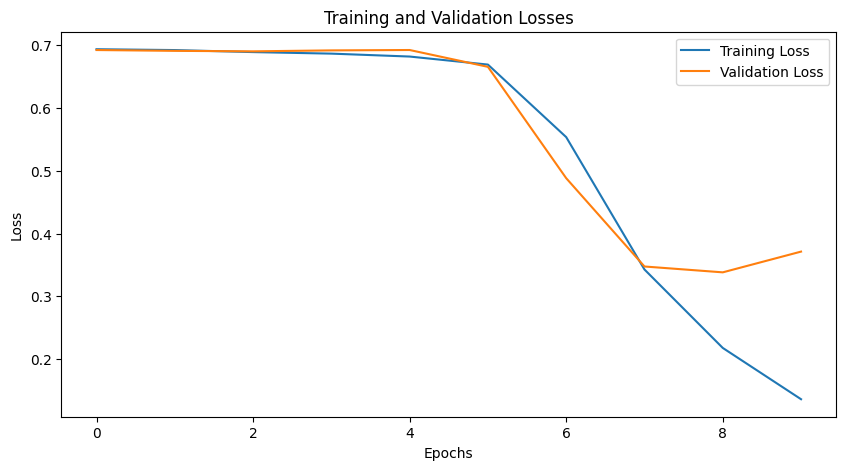

In [ ]:
# 손실 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 평가
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for texts, labels in tqdm(test_loader):
        outputs = model(texts)
        predicted = (torch.sigmoid(outputs.squeeze()) > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f' Test Accuracy: {100 * correct / total}%')

100%|██████████| 1250/1250 [00:20<00:00, 62.14it/s]

 Test Accuracy: 84.736%


### **Transformer**

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, dropout_ratio, device):
        super().__init__()
        assert hidden_dim % n_heads == 0
        self.hidden_dim = hidden_dim
        self.n_heads = n_heads
        self.head_dim = hidden_dim // n_heads

        self.fc_q = nn.Linear(hidden_dim, hidden_dim)
        self.fc_k = nn.Linear(hidden_dim, hidden_dim)
        self.fc_v = nn.Linear(hidden_dim, hidden_dim)
        self.fc_o = nn.Linear(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)
        self.scale = torch.sqrt(torch.tensor([self.head_dim], dtype=torch.float)).to(device)

    def forward(self, query, key, value, mask = None):
        batch_size = query.shape[0]
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        if mask is not None:
            energy = energy.masked_fill(mask==0, -1e10)
        attention = torch.softmax(energy, dim=-1)

        x = torch.matmul(self.dropout(attention), V)
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(batch_size, -1, self.hidden_dim)
        x = self.fc_o(x)

        return x, attention

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hidden_dim, pf_dim, dropout_ratio):
        super().__init__()
        self.fc_1 = nn.Linear(hidden_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x):
        x = self.dropout(torch.relu(self.fc_1(x)))
        x = self.fc_2(x)
        return x

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, input, input_mask):
        # Multi-Head Attention
        _src, _ = self.self_attention(input, input, input, input_mask)
        input = self.self_attn_layer_norm(input + self.dropout(_src)) # residual_connection + LayerNorm

        # FeedForward
        _src = self.positionwise_feedforward(input)
        input = self.ff_layer_norm(input + self.dropout(_src)) # residual_connection + LayerNorm

        return input

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=30522):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)
        self.layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, input, input_mask):
        batch_size = input.shape[0]
        src_len = input.shape[1]
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        input = self.dropout(self.tok_embedding(input) + self.pos_embedding(pos))

        for layer in self.layers:
            input = layer(input, input_mask)

        return input

In [ ]:
class TransformerClassification(nn.Module):
    def __init__(self, encoder, src_pad_idx, dropout_ratio, hidden_dim, num_labels, device):
        super().__init__()
        self.src_pad_idx = src_pad_idx
        self.encoder = encoder
        self.dropout = nn.Dropout(dropout_ratio)
        self.classifier = nn.Linear(hidden_dim, 1)

    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask

    def forward(self, input):
        src_mask = self.make_src_mask(input)
        x = self.encoder(input, src_mask)[:, 0, :]
        x = self.dropout(x)
        x = self.classifier(x)
        return x

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
src_pad_idx = tokenizer.pad_token_id

class IMDbDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float).unsqueeze(0)
        }


# 훈련 데이터셋 및 검증 데이터셋 생성
train_dataset = IMDbDataset(train_texts, train_labels, tokenizer)
valid_dataset = IMDbDataset(valid_texts, valid_labels, tokenizer)
test_dataset = IMDbDataset(test_texts, test_labels, tokenizer)

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


encoder = Encoder(input_dim=30522, hidden_dim=512, n_layers=6, n_heads=8, pf_dim=512, dropout_ratio=0.1, device=device)
model = TransformerClassification(encoder, src_pad_idx=src_pad_idx, dropout_ratio=0.1, hidden_dim=512, num_labels=2, device=device)
model.to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)

total_steps = len(train_loader) * 5
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=1000,
    num_training_steps=total_steps
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 40,722,945 trainable parameters


In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

TransformerClassification(
  (encoder): Encoder(
    (tok_embedding): Embedding(30522, 512)
    (pos_embedding): Embedding(30522, 512)
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=512, out_features=512, bias=True)
          (fc_k): Linear(in_features=512, out_features=512, bias=True)
          (fc_v): Linear(in_features=512, out_features=512, bias=True)
          (fc_o): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=512, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inp

In [ ]:
# 훈련 및 검증 함수
def train(model, loader, loss_fn, optimizer, scheduler, device):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for batch in tqdm(loader, desc=f"Train Epoch {epoch+1}"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        preds = torch.sigmoid(outputs) > 0.5
        total_correct += (preds == labels).all(dim=1).sum().item()
        total_samples += labels.size(0)

    train_loss = total_loss / len(loader)
    train_acc = total_correct / total_samples
    return train_loss, train_acc

def valid(model, loader, loss_fn, device):
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0

    with torch.no_grad():
        for batch in tqdm(loader, desc=f"Valid Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()
            preds = torch.sigmoid(outputs) > 0.5
            total_correct += (preds == labels).all(dim=1).sum().item()
            total_samples += labels.size(0)

    valid_loss = total_loss / len(loader)
    valid_acc = total_correct / total_samples
    return valid_loss, valid_acc

train_losses = []
valid_losses = []

epochs = 5
best_val_loss = float('inf')
model_save_path = '/content/drive/MyDrive/IIPL Lab/IMDB model/Transformer_model.pth'
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, loss_fn, optimizer, scheduler, device)
    valid_loss, valid_acc = valid(model, valid_loader, loss_fn, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}, Val Acc: {valid_acc*100:.2f}%')

    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        torch.save(model.state_dict(), model_save_path)
        print(f"Best model saved!")

Valid Epoch 1: 100%|██████████| 79/79 [00:55<00:00,  1.41it/s]


Train Loss: 0.6752, Validation Loss: 0.4241, Val Acc: 82.44%
Best model saved!


Valid Epoch 2: 100%|██████████| 79/79 [00:56<00:00,  1.41it/s]


Train Loss: 0.2867, Validation Loss: 0.3192, Val Acc: 87.10%
Best model saved!


Valid Epoch 3: 100%|██████████| 79/79 [00:56<00:00,  1.41it/s]


Train Loss: 0.1974, Validation Loss: 0.3360, Val Acc: 87.12%


Valid Epoch 4: 100%|██████████| 79/79 [00:55<00:00,  1.43it/s]


Train Loss: 0.1334, Validation Loss: 0.4481, Val Acc: 86.82%


Valid Epoch 5: 100%|██████████| 79/79 [00:55<00:00,  1.43it/s]

Train Loss: 0.0484, Validation Loss: 0.5595, Val Acc: 87.24%


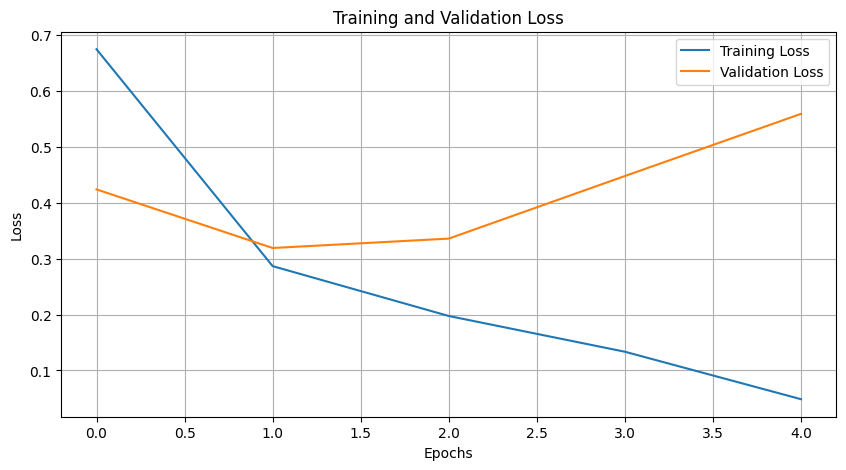

In [ ]:
# 훈련 및 검증 손실 그래프 그리기
plt.figure(figsize=(10, 5))  # 그래프의 크기 설정
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model_path = '/content/drive/MyDrive/IIPL Lab/IMDB model/Transformer_model.pth'
model.load_state_dict(torch.load(model_path))

def test(model, loader, loss_fn, device):
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0

    with torch.no_grad():
        for batch in tqdm(loader):
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()
            preds = torch.sigmoid(outputs) > 0.5
            total_correct += (preds == labels).all(dim=1).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = total_correct / len(loader.dataset)
    return avg_loss, accuracy

# 테스트 데이터셋을 사용하여 평가
test_loss, test_acc = test(model, test_loader, loss_fn, device)
print(f'Test Accuracy: {test_acc*100:.2f}%')

100%|██████████| 391/391 [05:03<00:00,  1.29it/s]

Test Accuracy: 86.11


### **BERT**

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# BERT 토크나이저 및 모델 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

# 데이터셋 정의
class IMDBDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=256,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = IMDBDataset(train_texts, train_labels)
valid_dataset = IMDBDataset(valid_texts, valid_labels)
test_dataset = IMDBDataset(test_texts, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# 최적화 및 스케줄러 설정
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 3  # 3 epoch
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=300,
    num_training_steps=total_steps
)
loss_fn = torch.nn.BCEWithLogitsLoss()
model_save_path = '/content/drive/MyDrive/IIPL Lab/IMDB model/BERT_model.pth'

def valid(model, data_loader, device, epoch):
    model.eval()
    total_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        for batch in tqdm(data_loader, desc=f"Valid Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            ).logits.squeeze()

            logits = outputs[:, 0]

            loss = loss_fn(logits, labels.float())

            preds = torch.sigmoid(logits).round()
            accuracy = torch.sum(preds == labels).item() / len(labels)
            total_loss += loss.item()
            total_accuracy += accuracy

    avg_loss = total_loss / len(data_loader)
    avg_accuracy = total_accuracy / len(data_loader)

    return avg_loss, avg_accuracy

# 모델 훈련 및 검증 루프
def train(model, train_loader, valid_loader, optimizer, scheduler, device, n_epochs):
    train_losses = []
    valid_losses = []
    best_valid_loss = float('inf')

    for epoch in range(n_epochs):
        model.train()
        total_train_loss = 0
        total_train_accuracy = 0

        for batch in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            model.zero_grad()
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            ).logits.squeeze()

            logits = outputs[:, 0]

            loss = loss_fn(logits, labels.float())
            loss.backward()
            optimizer.step()
            scheduler.step()

            preds = torch.sigmoid(logits).round()
            accuracy = torch.sum(preds == labels).item() / len(labels)
            total_train_loss += loss.item()
            total_train_accuracy += accuracy

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_accuracy = total_train_accuracy / len(train_loader)
        train_losses.append(avg_train_loss)

        valid_loss, valid_accuracy = valid(
            model,
            valid_loader,
            device,
            epoch
        )
        valid_losses.append(valid_loss)

        print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy*100:.2f}%')

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
            torch.save(model.state_dict(), model_save_path)
            print(f"Best Model saved!")

    return train_losses, valid_losses

train_losses, valid_losses = train(model, train_loader, valid_loader, optimizer, scheduler, device, n_epochs=3)

Valid Epoch 1: 100%|██████████| 157/157 [01:46<00:00,  1.47it/s]


Epoch 1/3, Train Loss: 0.3647, Valid Loss: 0.2290, Valid Acc: 90.86%
Best Model saved!


Valid Epoch 2: 100%|██████████| 157/157 [01:47<00:00,  1.47it/s]


Epoch 2/3, Train Loss: 0.1678, Valid Loss: 0.2266, Valid Acc: 91.52%
Best Model saved!


Valid Epoch 3: 100%|██████████| 157/157 [01:45<00:00,  1.48it/s]

Epoch 3/3, Train Loss: 0.0859, Valid Loss: 0.2633, Valid Acc: 91.44%


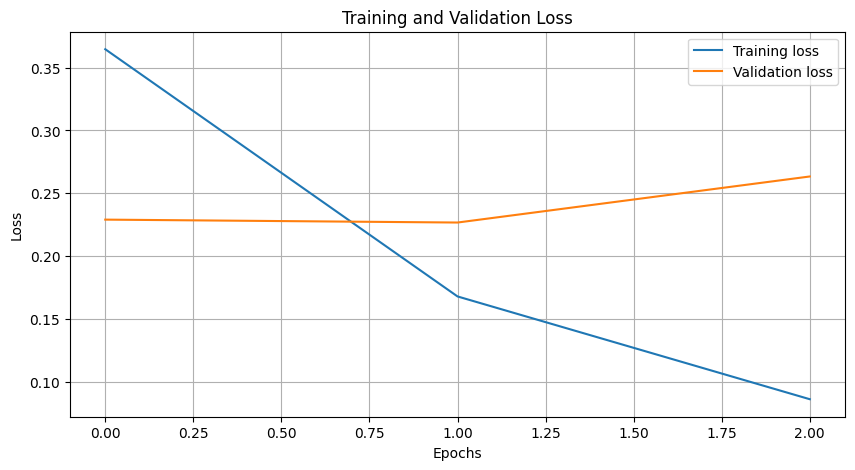

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model_save_path = '/content/drive/MyDrive/IIPL Lab/IMDB model/BERT_model.pth'

model_state_dict = torch.load(model_save_path)
model.load_state_dict(model_state_dict)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [11]:
def test(model, test_loader, device):
    model = model.eval()
    correct_predictions = 0
    total_accuracy = 0

    with torch.no_grad():
        for batch in tqdm(test_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            ).logits.squeeze()

            logits = outputs[:, 0]

            preds = torch.sigmoid(logits).round()
            accuracy = torch.sum(preds == labels).item() / len(labels)
            total_accuracy += accuracy

    test_acc = total_accuracy / len(test_loader)

    print(f'Test Accuracy: {test_acc*100:.2f}%')

test(model, test_loader, device)

100%|██████████| 782/782 [08:49<00:00,  1.48it/s]

Test Accuracy: 92.14%
